In [50]:
import torch
import os
import shutil
from tqdm import tqdm
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
from random import sample

random.seed(42)

In [12]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Dataset already exists on the disk. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n

def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [13]:
dataset_directory = os.path.join("./dataset")
os.mkdir(dataset_directory)

filepath = os.path.join(dataset_directory, "images.tar.gz")
download_url(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", filepath=filepath,
)
extract_archive(filepath)

filepath = os.path.join(dataset_directory, "annotations.tar.gz")
download_url(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", filepath=filepath,
)
extract_archive(filepath)

images.tar.gz: 100%|██████████| 755M/755M [02:10<00:00, 6.05MB/s]    
annotations.tar.gz: 100%|██████████| 18.3M/18.3M [00:14<00:00, 1.30MB/s]  


In [37]:
root_directory = os.path.join(dataset_directory)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

def preprocess_mask(mask):
    mask = np.float32(mask)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return Image.fromarray(np.uint8(mask))

In [55]:
filenames = [os.path.splitext(f)[0] for f in os.listdir(images_directory) if os.path.isfile(os.path.join(images_directory, f))]

In [59]:
train_images_filenames = sample(filenames,int(len(filenames)*0.7))
leftover_images_filenames = list(set(filenames).difference(set(train_images_filenames)))
val_images_filenames = sample(leftover_images_filenames,int(len(leftover_images_filenames)*0.3))
test_images_filenames = list(set(leftover_images_filenames).difference(set(val_images_filenames)))

print(f'train_images_filenames has {len(train_images_filenames)} images')
print(f'val_images_filenames has {len(val_images_filenames)} images')
print(f'test_images_filenames has {len(test_images_filenames)} images')

train_images_filenames has 5175 images
val_images_filenames has 665 images
test_images_filenames has 1552 images


In [60]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 2*rows))
    for i, image_filename in enumerate(images_filenames):
        image = Image.open(os.path.join(images_directory, f'{image_filename}.jpg')).convert('RGB')

        mask = Image.open(os.path.join(masks_directory, f'{image_filename}.png'))
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

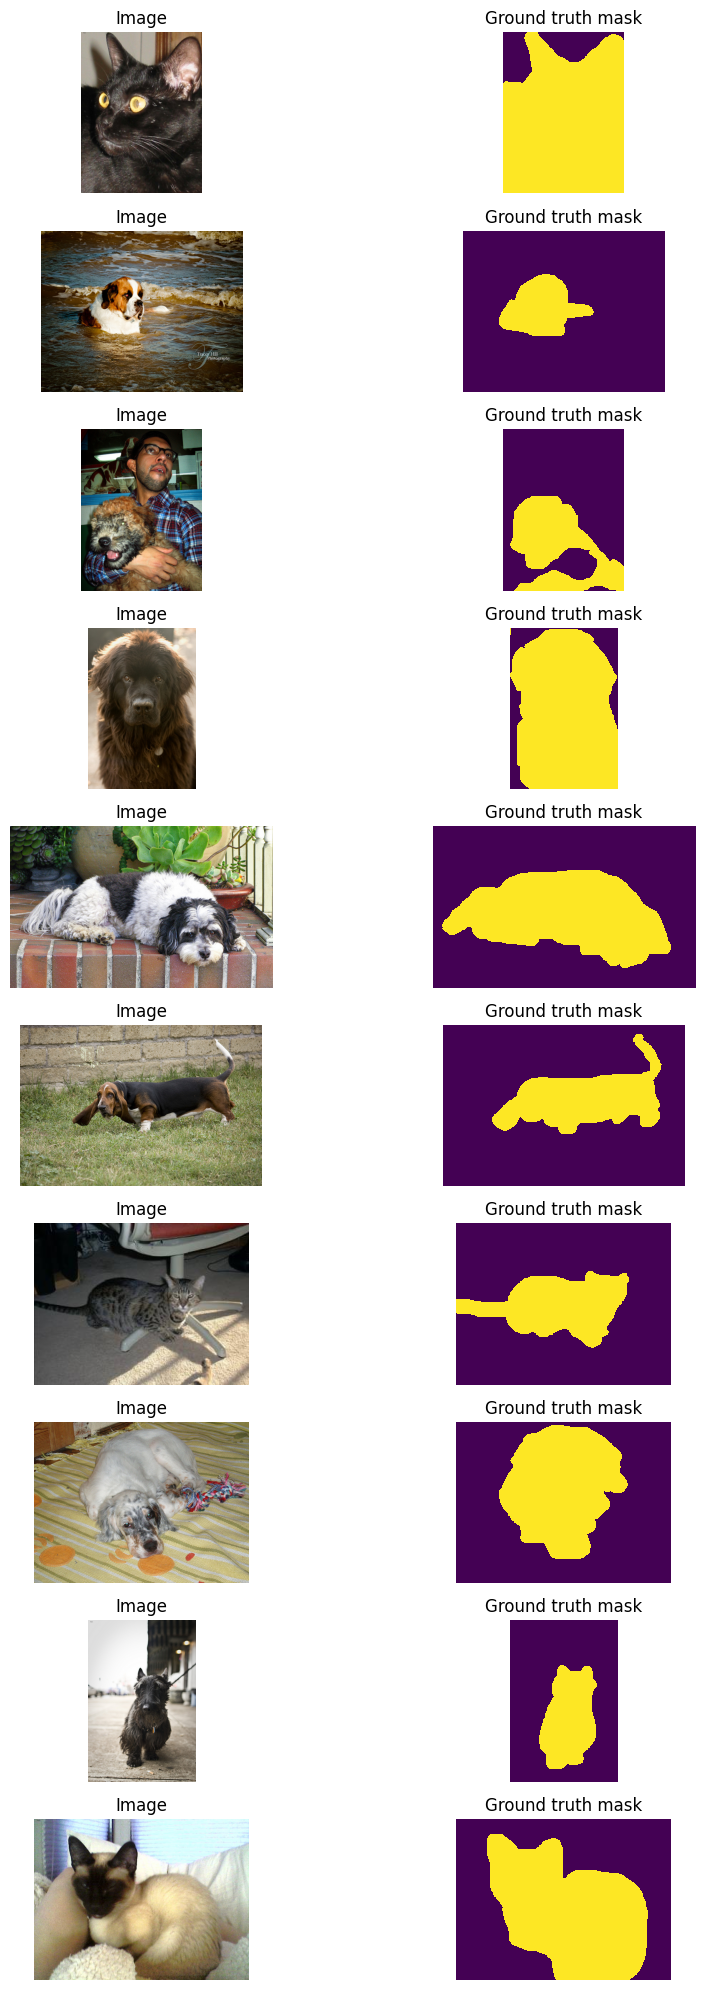

In [62]:
display_image_grid(train_images_filenames[:10], images_directory, masks_directory)

In [43]:
class OxfordPetDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None, transform_mask=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames.loc[idx] + '.jpg'
        image = Image.open(os.path.join(self.images_directory, image_filename)).convert('RGB')
        mask = Image.open(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")))
        mask = preprocess_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image)
            transformed_m = self.transform_mask(mask)
            image = transformed
            mask = transformed_m
        return image, mask

In [45]:
train_transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
target_transform = transforms.Compose([transforms.PILToTensor(),
                                       transforms.Resize((256, 256)),
                                       transforms.Lambda(lambda x: (x-1).squeeze().type(torch.LongTensor)) ])

In [ ]:
train_dataset = OxfordPetDataset(train_images_filenames,
                                 images_directory,
                                 masks_directory,
                                 transform=train_transform,
                                 transform_mask=target_transform)


val_dataset = OxfordPetDataset(val_images_filenames,
                               images_directory,
                               masks_directory,
                               transform=train_transform,
                               transform_mask=target_transform)

In [46]:
torch.cuda.is_available()

True

# need to implement Unet